# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [ ]:
!pip3 install opencv-python==4.5.1.48

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score

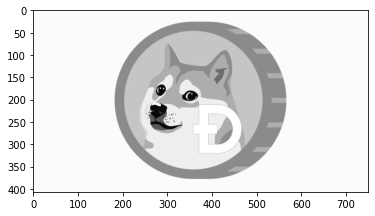

In [ ]:
img = cv2.imread('doge.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, 'gray');

In [ ]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    theta_step = 2 / phi_bins * np.pi
    lamda_step = (max_scale - min_scale) / scale_bins

    filters = np.zeros((scale_bins, phi_bins, size[0], size[1]))
    
    for i, theta in enumerate(np.arange(theta_step, 2 * np.pi + theta_step, theta_step)):
        for j, lamda in enumerate(np.arange(min_scale, max_scale, lamda_step)):
            kernel = cv2.getGaborKernel(size, 1, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            
            filters[j, i] = kernel

    return filters

In [ ]:
from IPython.html.widgets import interact, interactive, fixed

def demo_gabor(theta, lamda):
    kernel = filters[lamda, theta]
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

    fft2 = np.fft.fft2(kernel)
    shift = np.fft.fftshift(fft2)
    shift_abs = np.abs(shift)
    
    plt.figure(figsize = (10, 30))

    plt.subplot(1, 3, 1)
    plt.imshow(kernel, 'gray')

    plt.subplot(1, 3, 2)
    plt.imshow(fimg, 'gray')

    plt.subplot(1, 3, 3)
    plt.imshow(shift_abs, 'gray')


size = (15, 15)
phi_bins = 10
scale_bins = 10
max_scale = np.pi
min_scale = np.pi / 8

filters = gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale)
interact(demo_gabor, theta=(0, phi_bins - 1, 1), lamda=(0, scale_bins - 1, 1));

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=4, description='theta', max=9), IntSlider(value=4, description='lamda', …

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 ближайших к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/sirius-dataset/sirius-traffic-lights-competition.zip'

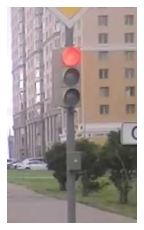

In [ ]:
img = cv2.imread('/content/train_val/pic/pic000000.jpg')

def show(img, size=3):
    plt.figure(figsize=(size,size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
show(img)

In [ ]:
def get_descriptor(image):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    kp = np.array(kp)
    des = np.array(des)

    if len(kp) > 100:
        mask = np.arange(len(kp))
        choisen = np.random.choice(mask, 100)
        kp = kp[choisen]
        des = des[choisen]

    return kp, des

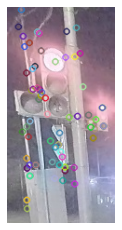

In [ ]:
img = cv2.imread('/content/train_val/pic/pic000100.jpg')

kp, des = get_descriptor(img)
sift_img = img.copy()
sift_img = cv2.drawKeypoints(sift_img, kp, sift_img)

show(sift_img)

In [ ]:
train_path = 'test/pic/'
train_keys = [x.split('.')[0] for x in os.listdir(train_path)]

des_list = []
kp_list = []
images = []
img_list = []

for i, name in enumerate(tqdm(train_keys)):
    img = cv2.imread(train_path + name + '.jpg')
    images.append(img)
    
    kp, des = get_descriptor(img)
    
    if len(kp) > 0:
        des_list += des.tolist()
        kp_list += kp.tolist()
        img_list += [i] * len(des)

kp_list = np.array(kp_list)
img_list = np.array(img_list)
des_df = pd.DataFrame(des_list)

In [ ]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=30, random_state=0).fit(des_df)

In [ ]:
def get_keypoint_img(keypoint, img):
    x, y = keypoint.pt
    x, y = int(np.round(x)), int(np.round(y))
    angle = keypoint.angle
    r = int(round(keypoint.size))

    matrix = cv2.getRotationMatrix2D((x, y), angle, 1.0)
    img_copy = img.copy()
    rotated_img = cv2.warpAffine(img_copy, matrix, img_copy.shape[1::-1], flags=cv2.INTER_LINEAR)

    cut = rotated_img[y - r:y + r, x - r:x + r]

    return cut

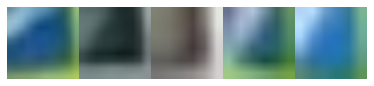

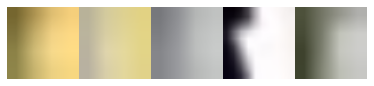

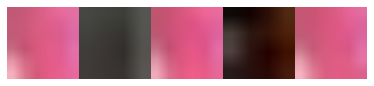

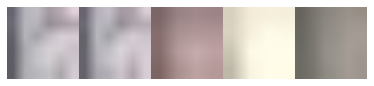

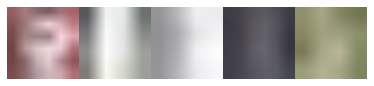

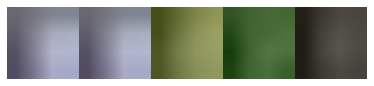

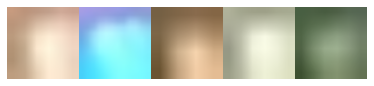

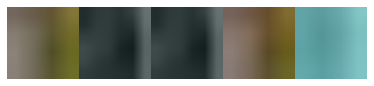

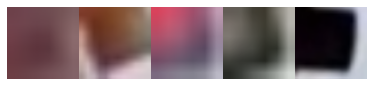

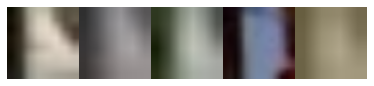

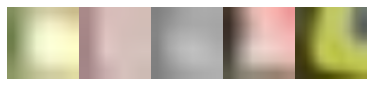

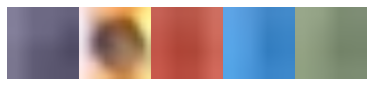

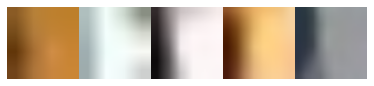

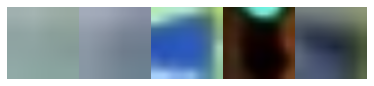

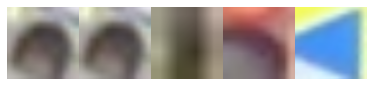

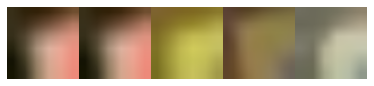

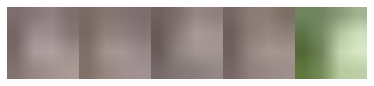

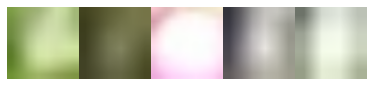

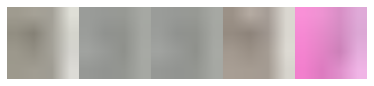

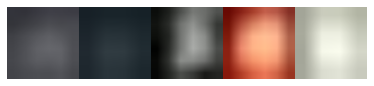

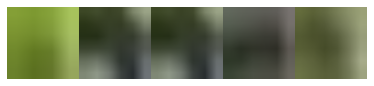

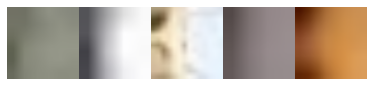

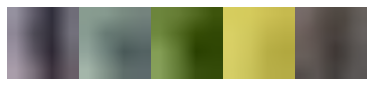

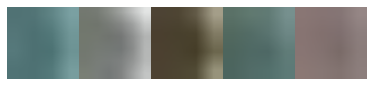

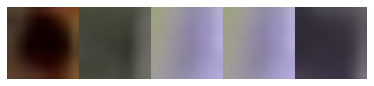

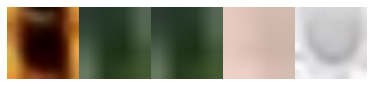

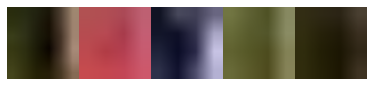

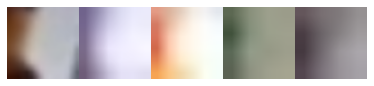

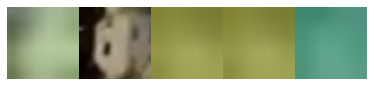

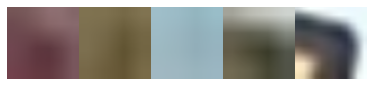

In [ ]:
values = des_df.values

for centroid in kmeans.cluster_centers_:
    idx = np.linalg.norm(values - centroid, axis=1).argsort()[:5]
    keypoints = kp_list[idx]
    top_imgs = img_list[idx]

    imgs = [cv2.resize(get_keypoint_img(keypoint, images[img_id]), (64, 64)) for keypoint, img_id in zip(keypoints, top_imgs)]
    show(np.hstack(imgs), size = 5)

### **Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*

Summary: 

| Algo     |                         Features   |  OOF        |     LB     |
|----------|:----------------------------------:|------------:|------------|
|3 Folds RF|RGB, HSV, LAB Hists - 50 per channel|       0.8992|     0.8806 |
|3 Folds RF|50 Hists + Mean Brightest Area      |       0.9038|     0.8853 |
|3 Folds RF|50 + 10 Hists + Mean Brightest Area |       0.9038|     0.8893 |
|   Full RF|50 + 10 Hists + Mean Brightest Area |       -     |     0.8912 |
|3 Folds LGBM|50 + 10 Hists + Mean Brightest Area |     0.9197|     0.8980 |
|3 Folds LGBM|50 + Mean Brightest Area          |     0.9190  |     0.8993 |
|Full    LGBM|50 + Mean Brightest Area          |     -  |     0.9012 |

Изначально был бейзлайн - просто 3 гистограммы разных цветовых схем, которые можно будет засунуть в LGBM. В принципе этого было достаточно на 0.89. Еще добавило определение самых ярких областей, которые считались в области (11, 11) по признаку 0.5 * saturation + 0.5 * value. Когда цвет очень явный и выделяется, то эта штука хорошо определяет. Но если что-то не очень хорошо заметно, то он теряется. Еще думал искать топ-2 или топ-3 таких областей, но не успел. Также он теряется на двух светофорах.

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import cv2
from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

In [ ]:
keys = pd.read_csv('/content/train_val/keys.csv')

In [ ]:
lb = LabelEncoder()
keys['category'] = lb.fit_transform(keys['category'])

In [ ]:
FIXED_IMG_HEIGHT = 128
FIXED_IMG_WIDTH = 128

def resize_img(img, res_shape=(FIXED_IMG_HEIGHT, FIXED_IMG_WIDTH)):
    height, width = img.shape[:2]
    resized_width = int(res_shape[0] * (float(width) / height))
    img_resized = cv2.resize(img, (resized_width, int(res_shape[0])))
    return img_resized

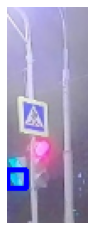

In [ ]:
def get_lightest_box(img_hsv, box_size=(10, 10)):
    s_values = (img_hsv[:, :, 1] - np.mean(img_hsv[:, :, 1])) / np.std(img_hsv[:, :, 1])
    v_values = (img_hsv[:, :, 2] - np.mean(img_hsv[:, :, 2])) / np.std(img_hsv[:, :, 2])
    sv_average = 0.5 * s_values + 0.5 * v_values

    kernel = np.ones(box_size, np.float32) / 100.
    sv_average_filtered = cv2.filter2D(sv_average, -1, kernel)

    sv_average_filtered = sv_average_filtered[int(box_size[0] / 2): -int(box_size[0] / 2), int(box_size[0] / 2): -int(box_size[1] / 2)]
    
    max_pos = np.unravel_index(
        np.argmax(sv_average_filtered, axis=None),
        sv_average_filtered.shape)
    
    return max_pos

img = cv2.imread('/content/train_val/pic/pic000011.jpg')

img = resize_img(img)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

box_size = (11, 11)
(light_x, light_y) = get_lightest_box(img_hsv, box_size=box_size)

color = (255, 0, 0)
thickness = 2
img_rect = cv2.rectangle(img, (light_y, light_x), 
                         (light_y + box_size[1], light_x + box_size[0]), color, thickness)

show(img_rect)

In [ ]:
def get_colour_features(path, values, bins=50):

    colours_dict = {}

    for name in tqdm(values):
        img = cv2.imread(path + name + '.jpg')

        features = []

        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

        for i in range(3):
            features += list(cv2.calcHist([img_hsv], [i], None, [bins], [0, 256]).reshape(-1))
            features += list(cv2.calcHist([img_rgb], [i], None, [bins], [0, 256]).reshape(-1))
            features += list(cv2.calcHist([img_lab], [i], None, [bins], [0, 256]).reshape(-1))

        img = resize_img(img)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        box_size = (11, 11)
        (light_x, light_y) = get_lightest_box(img_hsv, box_size=box_size)
        img_box_rgb = img[light_x: light_x + box_size[0], light_y: light_y + box_size[1]]
        img_box_hsv = cv2.cvtColor(img_box_rgb, cv2.COLOR_BGR2HSV)
        img_box_lab = cv2.cvtColor(img_box_rgb, cv2.COLOR_BGR2Lab)

        light_rgb_mean = np.mean(img_box_rgb.reshape(-1, 3), axis=0)
        light_hsv_mean = np.mean(img_box_hsv.reshape(-1, 3), axis=0)
        light_lab_mean = np.mean(img_box_lab.reshape(-1, 3), axis=0)

        features += list(np.concatenate([light_rgb_mean, light_hsv_mean, light_lab_mean]))

        colours_dict[name] = features

    simple_colours_df = pd.DataFrame.from_dict(colours_dict, orient='index')
    return simple_colours_df

In [ ]:
train_path = 'train_val/pic/'
test_path = 'test/pic/'
test_keys = [x.split('.')[0] for x in os.listdir(test_path)]

X = get_colour_features(train_path, keys['id'].values, 50)
X_test = get_colour_features(test_path, test_keys, 50)
y = keys['category']

In [ ]:
X_test = X_test.sort_index()

In [ ]:
X.shape, X_test.shape, y.shape

((45633, 459), (10699, 459), (45633,))

In [ ]:
params = {
          'num_leaves': 100,
          'min_child_weight': 0.008023947837732857,
          'feature_fraction': 0.5341568665265988,
          'bagging_fraction': 0.32474760774990463,
          'min_data_in_leaf': 33,
          'objective': 'multiclass',
          'num_classes': 5,
          'max_depth': 8,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'multi_error',
          "verbosity": -1,
          'reg_alpha': 1.7722447692966574,
          'reg_lambda': 1.1987156815341724,
          'random_state': 47,
         }

In [ ]:
preds = np.zeros((len(X_test), 5))
oof = np.zeros((len(X), 5))

folds = KFold(n_splits=3, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    
    preds += clf.predict(X_test) / folds.n_splits
    oof[test_idx] = clf.predict(X.iloc[test_idx])

    # clf = RandomForestClassifier(random_state=20)
    # clf.fit(X.iloc[trn_idx], y.iloc[trn_idx])
    
    # preds += clf.predict_proba(X_test) / folds.n_splits
    # oof[test_idx] = clf.predict_proba(X.iloc[test_idx])

    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))

pred_classes_test = np.argmax(preds, axis=1)
pred_classes = np.argmax(oof, axis=1)
print('OOF score: ', accuracy_score(pred_classes, y))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_error: 0.00989416	valid_1's multi_error: 0.080994
[1000]	training's multi_error: 0	valid_1's multi_error: 0.0767865
Early stopping, best iteration is:
[896]	training's multi_error: 0	valid_1's multi_error: 0.0771152
Fold 1 finished in 0:10:00.051900
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_error: 0.00976267	valid_1's multi_error: 0.0886201
[1000]	training's multi_error: 0	valid_1's multi_error: 0.0836894
Early stopping, best iteration is:
[987]	training's multi_error: 0	valid_1's multi_error: 0.0838209
Fold 2 finished in 0:10:04.852598
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_error: 0.0102557	valid_1's multi_error: 0.085596
[1000]	training's multi_error: 0	valid_1's multi_error: 0.0813227
Early stopping, best iteration is:
[875]	training's multi_error: 0	va

In [ ]:
%%time

clf = LGBMClassifier(**params, n_estimators=900)
clf.fit(X, y)

preds = clf.predict_proba(X_test)

In [ ]:
pred_classes_test = np.argmax(preds, axis=1)
label_preds = lb.inverse_transform(pred_classes_test)

submission = pd.DataFrame()
submission['id'] = X_test.index
submission['category'] = label_preds

submission.to_csv('submission_lgb_full.csv', index=False)